# 批量规范化
## 从零开始

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# moving_mean：全局均值，moving_var：全局方差，eps：避免除0，momentum：用来更新moving_mean和moving_var
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差（此处无法获得批量，取用全局）
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)   # 2表示全连接层，4表示卷积层
        if len(X.shape) == 2:   # （批量大小，特征）
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)   # （批量大小，通道，高，宽）
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)   # 数据形状为（1,n,1,1），keepdim=True保持输入输出维度一致
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差（因为当前无法获得全局的均值和方差，使用此方法通过当前所获得的数据逐步逼近真实的均值和方差）
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

## 创建一个正确的BatchNorm图层

In [2]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 应用BatchNorm于LeNet模型

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

## 在Fashion-MNIST数据集上训练网络

loss 0.263, train acc 0.903, test acc 0.738
26039.7 examples/sec on cuda:0


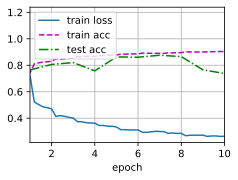

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 拉伸参数gamma和偏移参数beta

In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.3916, 1.9947, 2.2996, 2.2922, 2.8546, 4.4196], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-2.2685, -0.0592,  1.5307, -1.4613, -3.2358,  2.5442], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## 简明实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

## 使用相同超参数来训练模型

loss 0.273, train acc 0.900, test acc 0.820
52780.8 examples/sec on cuda:0


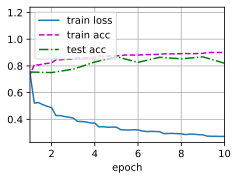

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())